In [37]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
# import statsmodels.api as sm
import os
import seaborn as sns
sns.set()
from joblib import dump
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from mpl_toolkits.mplot3d import Axes3D

## BUILDING THE DATASET

In [38]:
#create dataset
data = pd.DataFrame(columns=['Anchor_name', 'RSSI', 'distance'])

# Reading gathered data files
files_list = sorted(list(filter(lambda x: ("detectedDevs" in x), os.listdir("/home/aaron/Trabajo/interaction-tracker-updated/PositionTracker/src/Data_Collection/Offline/3anchor_1movil/proximity"))))

#concatenate file's data to build the dataset
for file in files_list:
    filename_split = file.split('_')
    distance = float(filename_split[2]) / 100
    df = pd.read_json('/home/aaron/Trabajo/interaction-tracker-updated/PositionTracker/src/Data_Collection/Offline/3anchor_1movil/proximity/'+file)

    df.drop(['devname'], axis=1, inplace=True)
    df.rename(columns={'launchpadId':'Anchor_name'}, inplace=True)
    df.insert(loc=2, column='distance', value=np.repeat(distance, df.shape[0]))

    data = data.append(df)

data.reset_index(drop=True, inplace=True)

#create the column "dist_<_1m" to allow performing classification
data.insert(3, 'dist_<_1m', data['distance'].apply(lambda dist: 1 if dist < 1.0 else 0))
data

,Anchor_name,RSSI,distance,dist_<_1m
0,ANC-4278,-25,0.0,1
1,ANC-4278,-25,0.0,1
2,ANC-4278,-25,0.0,1
3,ANC-4278,-25,0.0,1
4,ANC-4278,-25,0.0,1
...,...,...,...,...
12109,ANC-3b6c,-55,0.8,1
12110,ANC-3b6c,-48,0.8,1
12111,ANC-3b6c,-48,0.8,1
12112,ANC-3b6c,-46,0.8,1


## PREPROCESSING

In [39]:
#imbalanced dataset. down-sample majority class
data_maj = data[data['dist_<_1m'] == 1]
data_min = data[data['dist_<_1m'] == 0]

data_maj_downsampled = resample(data_maj, replace=False, n_samples=data_min.shape[0], random_state=176341)

data = pd.concat([data_maj_downsampled, data_min])
print(data)
print(data['dist_<_1m'].value_counts())

      Anchor_name RSSI  distance  dist_<_1m
3643     ANC-4278  -48       0.8          1
4164     ANC-4acf  -26       0.0          1
3585     ANC-4278  -46       0.8          1
8342     ANC-3b6c  -27       0.0          1
7163     ANC-4acf  -43       0.6          1
...           ...  ...       ...        ...
10594    ANC-3b6c  -63       3.0          0
10595    ANC-3b6c  -63       3.0          0
10596    ANC-3b6c  -64       3.0          0
10597    ANC-3b6c  -61       3.0          0
10598    ANC-3b6c  -61       3.0          0

[9082 rows x 4 columns]
1    4541
0    4541
Name: dist_<_1m, dtype: int64


Text(0.5, 1.0, 'ANC-3b6c')

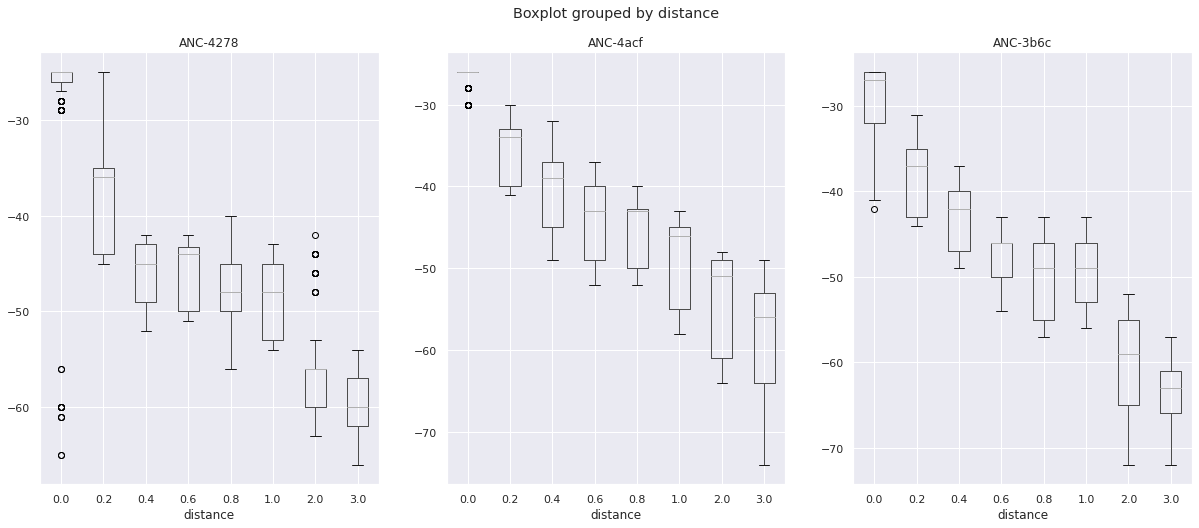

In [40]:
#boxplot for each anchor
fig, ax = plt.subplots(1,3,figsize=(20,8))
anchor_names_list = data['Anchor_name'].unique()

data[data['Anchor_name'] == anchor_names_list[0]].boxplot(column='RSSI', by='distance', ax=ax[0])
data[data['Anchor_name'] == anchor_names_list[1]].boxplot(column='RSSI', by='distance', ax=ax[1])
data[data['Anchor_name'] == anchor_names_list[2]].boxplot(column='RSSI', by='distance', ax=ax[2])
ax[0].set_title(anchor_names_list[0])
ax[1].set_title(anchor_names_list[1])
ax[2].set_title(anchor_names_list[2])

Text(0.5, 1.0, 'Mixed data')

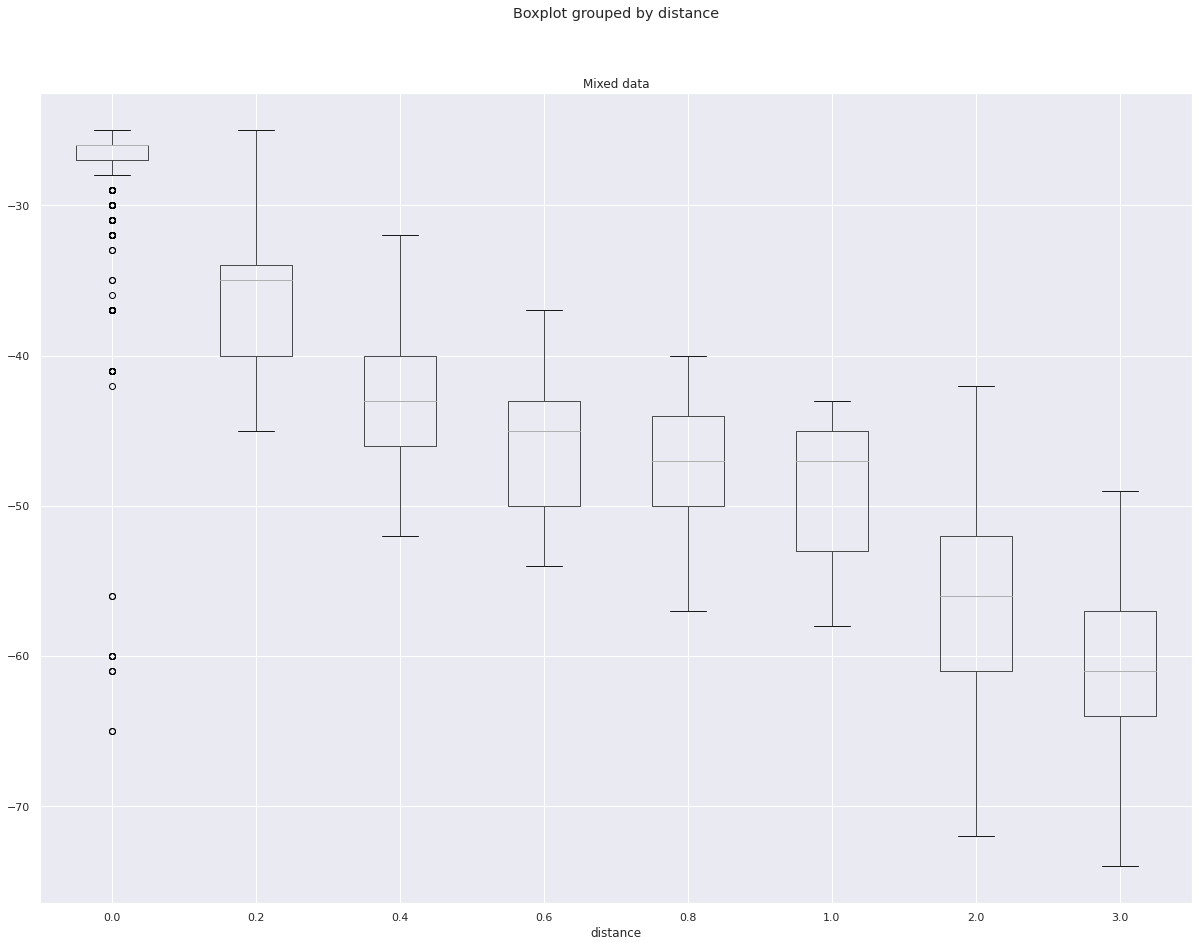

In [41]:
#Mixing data from all anchors
fig, ax = plt.subplots(figsize=(20,15))

data.boxplot(column='RSSI', by='distance', ax=ax)
ax.set_title("Mixed data")

In [42]:
#Remove distance=0 & distance=2.0 outliers  
indexnames = data[(data.distance == 0) & (data.RSSI < -35)].index
data.drop(indexnames, inplace=True, axis=0)

#indexnames = data[(data.distance == 2.0) & (data.RSSI > -50)].index
#data.drop(indexnames, inplace=True, axis=0)

## VISUALIZATION

### PCA per anchor

In [43]:
data_numerical = pd.get_dummies(data, prefix='01' ,columns=['Anchor_name'])
columns = data_numerical.columns.delete(1).delete(1) #delete target variable
print(columns)
data_numerical_standarized = data_numerical.copy()
data_numerical_standarized[columns] = StandardScaler().fit_transform(data_numerical[columns])
data_numerical_standarized

Index(['RSSI', '01_ANC-3b6c', '01_ANC-4278', '01_ANC-4acf'], dtype='object')


,RSSI,distance,dist_<_1m,01_ANC-3b6c,01_ANC-4278,01_ANC-4acf
3643,-0.028144,0.8,1,-0.700288,1.399737,-0.706636
4164,1.999308,0.0,1,-0.700288,-0.714420,1.415156
3585,0.156170,0.8,1,-0.700288,1.399737,-0.706636
8342,1.907151,0.0,1,1.427983,-0.714420,-0.706636
7163,0.432640,0.6,1,-0.700288,-0.714420,1.415156
...,...,...,...,...,...,...
10594,-1.410498,3.0,0,1.427983,-0.714420,-0.706636
10595,-1.410498,3.0,0,1.427983,-0.714420,-0.706636
10596,-1.502655,3.0,0,1.427983,-0.714420,-0.706636
10597,-1.226184,3.0,0,1.427983,-0.714420,-0.706636


In [44]:
colors_dist = {0: 'k', 1:'r'}

myPCA = PCA(n_components=3)
myPCA.fit(data_numerical_standarized[columns]);
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.38857721 0.37622496 0.23519783]
[0.38857721 0.76480217 1.        ]


In [45]:
transformed_data = myPCA.transform(data_numerical_standarized[columns])
data_numerical_standarized[['PC1','PC2','PC3']] = transformed_data[:,:3]
data_numerical_standarized

,RSSI,distance,dist_<_1m,01_ANC-3b6c,01_ANC-4278,01_ANC-4acf,PC1,PC2,PC3
3643,-0.028144,0.8,1,-0.700288,1.399737,-0.706636,-0.137650,1.711881,0.017651
4164,1.999308,0.0,1,-0.700288,-0.714420,1.415156,2.101564,-0.730958,-1.431722
3585,0.156170,0.8,1,-0.700288,1.399737,-0.706636,-0.080484,1.715253,-0.157540
8342,1.907151,0.0,1,1.427983,-0.714420,-0.706636,-0.775530,-0.946846,-2.277746
7163,0.432640,0.6,1,-0.700288,-0.714420,1.415156,1.615647,-0.759628,0.057408
...,...,...,...,...,...,...,...,...,...
10594,-1.410498,3.0,0,1.427983,-0.714420,-0.706636,-1.804531,-1.007559,0.875707
10595,-1.410498,3.0,0,1.427983,-0.714420,-0.706636,-1.804531,-1.007559,0.875707
10596,-1.502655,3.0,0,1.427983,-0.714420,-0.706636,-1.833115,-1.009245,0.963303
10597,-1.226184,3.0,0,1.427983,-0.714420,-0.706636,-1.747365,-1.004186,0.700516


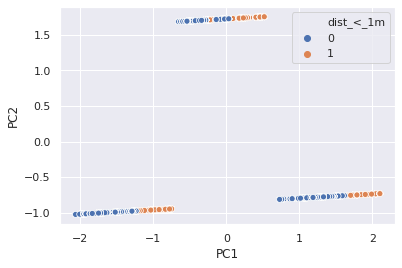

In [46]:
sns.scatterplot(x='PC1', y='PC2', hue='dist_<_1m', data=data_numerical_standarized)

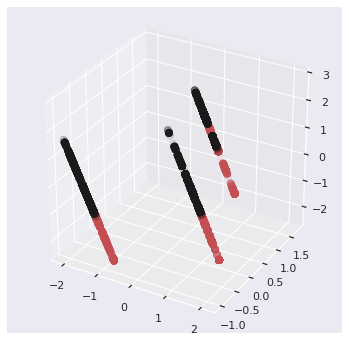

In [47]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(data_numerical_standarized.PC1,
            data_numerical_standarized.PC2,
            zs=data_numerical_standarized.PC3,
            depthshade=False,
            alpha=0.1,
            c=data_numerical_standarized['dist_<_1m'].apply(lambda x: colors_dist[x]), s=50)

## USING GAUSSIAN NAIVE BAYES MODEL

### BUILDING TRAIN & TEST SETS

In [48]:
#split in train and test data
train, test = train_test_split(data, test_size=data.shape[0]//3)

### CONVERT CATEGORICAL DATA TO NUMERICAL 

In [49]:
#convert categorical data to numerical data

ANCHORS = data['Anchor_name'].unique()
print(ANCHORS)
train.replace({ANCHORS[0]: 0, ANCHORS[1]: 1, ANCHORS[2]: 2}, inplace=True)
test.replace({ANCHORS[0]: 0, ANCHORS[1]: 1, ANCHORS[2]: 2}, inplace=True)

print(train)

['ANC-4278' 'ANC-4acf' 'ANC-3b6c']
       Anchor_name  RSSI  distance  dist_<_1m
6827             1   -39       0.4          1
6801             1   -37       0.4          1
11186            2   -46       0.6          1
2529             0   -46       0.4          1
6235             1   -53       3.0          0
...            ...   ...       ...        ...
5775             1   -35       0.2          1
7983             1   -50       0.8          1
4684             1   -45       1.0          0
1782             0   -37       0.2          1
10721            2   -39       0.4          1

[6006 rows x 4 columns]


### APPLY GAUSSIAN NAIVE-BAYES

In [50]:
#apply a gaussian naive-bayes
NB_model = GaussianNB()
NB_model.fit(train.loc[:,'Anchor_name':'RSSI'], train['dist_<_1m'])

#using cross validation
NB_model_cv = GaussianNB()
scores = cross_val_score(NB_model_cv, train.loc[:,'Anchor_name':'RSSI'], train['dist_<_1m'], cv=10)

#compute confusion matrix

y_test_pred = NB_model.predict(test.loc[:,'Anchor_name':'RSSI'])
print(confusion_matrix(test['dist_<_1m'], y_test_pred))

print(f'cross validation score: mean->{scores.mean()} std->{scores.std()}\n')

#generate classification report
print("CLASSIFICATION REPORT")
y_test_pred = NB_model.predict(test.loc[:, 'Anchor_name':'RSSI'])
print(classification_report(y_true=test['dist_<_1m'], y_pred=y_test_pred))

[[1293  254]
 [ 310 1145]]
cross validation score: mean->0.8123524681087076 std->0.01483677297710099

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1547
           1       0.82      0.79      0.80      1455

    accuracy                           0.81      3002
   macro avg       0.81      0.81      0.81      3002
weighted avg       0.81      0.81      0.81      3002



## USING SVC

### CONVERT CATEGORICAL DATA TO NUMERICAL

In [15]:
data_numerical = pd.get_dummies(data, prefix='01', columns=['Anchor_name'])

### BUILDING TRAIN & TEST SETS

In [16]:
#split in train and test data
X_train, X_test, y_train, y_test = train_test_split(data_numerical.loc[:,['RSSI','01_ANC-3b6c','01_ANC-4278','01_ANC-4278']], data_numerical.loc[:,['dist_<_1m']], test_size=data.shape[0]//3)

### SCALE TRAIN & TEST SETS SEPARATELY

In [1]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'StandardScaler' is not defined

### APPLY SVC

In [18]:
svc = SVC(class_weight='balanced')

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
Cs = [0.0001, 0.001, 0.1, 0.5, 1, 2, 3, 10, 50 ,100, 1000]

trc = GridSearchCV(estimator=svc,
                   param_grid={
                       'C': Cs,
                       'kernel': kernels
                   },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=10,
                   n_jobs=-1,
                   return_train_score=True,
                   refit='f1_macro')

svc_model_5CV = trc.fit(X_train, y_train)

print(svc_model_5CV.best_score_)
print(svc_model_5CV.best_params_)

0.8613161434378279
{'C': 1000, 'kernel': 'rbf'}


In [19]:
# Try 'poly' kernel (the best for this case) with different degrees

svc = SVC(C=2, kernel='poly', class_weight='balanced')

degrees = [2,3,4,5,6,7,8,9,10]

trc = GridSearchCV(estimator=svc,
                   param_grid={
                       'degree': degrees
                   },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=5,
                   n_jobs=-1,
                   return_train_score=True,
                   refit='f1_macro')

svc_model_5CV = trc.fit(X_train, y_train)

print(svc_model_5CV.best_score_)
print(svc_model_5CV.best_params_)

0.8629023239511862
{'degree': 6}


In [20]:
pd.DataFrame(svc_model_5CV.cv_results_).loc[:, [
    'mean_fit_time',
    'std_fit_time',
    'param_C',
    'param_kernel',
    'mean_test_accuracy',
    'std_test_accuracy',
    'mean_test_recall_macro',
    'std_test_recall_macro',
    'mean_test_f1_macro',
    'std_test_f1_macro',
]].sort_values(by='mean_test_f1_macro',ascending=False)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['param_C', 'param_kernel'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

### RE-TRAIN WITH TEST DATA USING THE BEST MODEL

In [21]:
svm = SVC(C=2, kernel='poly', degree=3, class_weight='balanced')
svm.fit(X_train,y_train)

scores = cross_val_score(svm, X_train, y_train, cv=10)
scores_recall = cross_val_score(svm, X_train, y_train, cv=10,scoring='recall_macro')
scores_f_score = cross_val_score(svm, X_train, y_train, cv=10,scoring='f1_macro')
[np.mean(scores),np.mean(scores_recall),np.mean(scores_f_score)]

[0.8592727064154406, 0.8590988413308338, 0.8590981834915624]

In [22]:
y_pred = svm.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1467
           1       0.82      0.89      0.85      1485

    accuracy                           0.85      2952
   macro avg       0.85      0.85      0.85      2952
weighted avg       0.85      0.85      0.85      2952

